In [1]:
from bert_embedding import BertEmbedding

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
CITY = 'sydney'

In [3]:
def zomatoPreprocess(city):
    zomato = pd.read_csv(city+'.csv')
    zomato = zomato[['name','food_items']].dropna(axis=0)
    
    food = zomato.food_items.apply(lambda x:[food.rstrip() 
                                             for food 
                                             in (str(x).replace('\\n','').split(','))])
    new_f = ''
    new_food = []
    for f in food:
        for i in range(len(f)):
            if i == len(f)-1: new_f += f[i]
            else: new_f += f[i]+', '
        new_food += [new_f]
        new_f = ''
        
    names = zomato.name.values
    
    return new_food, names

In [72]:
f,n = zomatoPreprocess(CITY)
f[:3]

['Coffee, Salmon, Burgers, Pancakes, Salad, Miso, Bruschettas',
 'Matcha Fondant, Coffee, Latte, Baked Cheesecake, Swiss Roll, Chicken Sandwich, Chocolate Cake',
 'Sashimi, Sea Food, Wagyu Meat, Beef Tongue, Scallops, Prawn, Sushi']

In [5]:
def stack(embeddings,stacked=[],n=0):

    if len(stacked)>0: x = stacked
    else: x = embeddings[0]
    
    try:stacked = np.add(np.array(x), embeddings[1])
    except:return np.array(x)
    
    n += 1
    
    return stack(embeddings[1:],stacked=stacked,n=n)



def __bagofBERTs(restaurants,berts):
    
    output = []
    
    for restaurant,(cuisines,embeddings) in zip(restaurants,berts):
        embedding = stack(embeddings)
        output += [(restaurant,cuisines,embedding)]
        
    return output



def getEmbeddings(n_restaurants=None,city=CITY):
    
    print('Cleaning Zomato data for {}.\n'.format(city))
    cuisines, names = zomatoPreprocess(CITY.lower())
    
    if n_restaurants == None: n_restaurants = len(cuisines)
    
    print('Retrieving BERT sentence representations for {} restuarants...\n'.format(n_restaurants))
    __bert_embedding = BertEmbedding(model='bert_12_768_12')
    __berts = __bert_embedding(cuisines[:n_restaurants])
    bagofembeddings = __bagofBERTs(names, __berts)
    
    print('Complete.')
    
    filtrd = [(n,c,e) for n,c,e
              in bagofembeddings 
                  if len(e.shape)>0]

    cuisines = [c for n,c,e in filtrd]
    embeds = [e for n,c,e in filtrd]
    names = [n for n,c,e in filtrd]
    
    return names,cuisines,embeds,bagofembeddings
    

In [11]:
names, food, embeds, bag = getEmbeddings(n_restaurants=1000)

Cleaning Zomato data for sydney.

Retrieving BERT sentence representations for 1000 restuarants...

Complete.


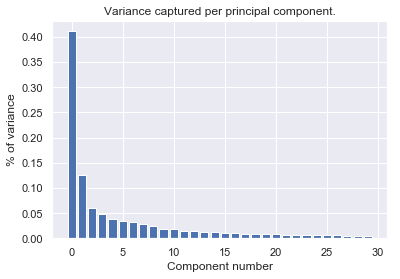

In [12]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

summed = sum(pca.explained_variance_)

plt.bar(range(len(pca.explained_variance_)),[i/summed for i in (pca.explained_variance_)])
plt.title('Variance captured per principal component.')
plt.ylabel('% of variance')
plt.xlabel('Component number')
plt.show()

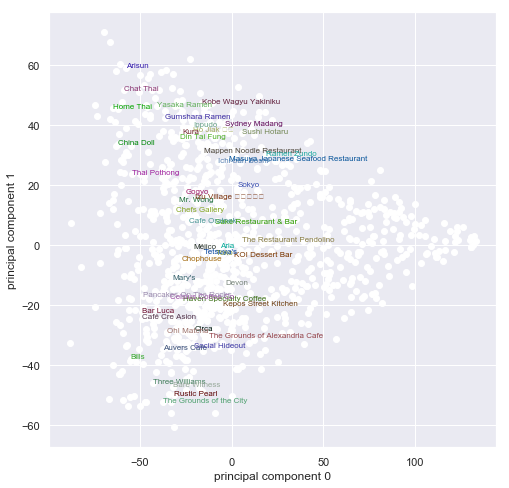

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(pca0,pca1,c='white')
for i, x, y in zip(names, pca0[:50], pca1[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.xlabel('principal component 0')
plt.ylabel('principal component 1')
plt.show()

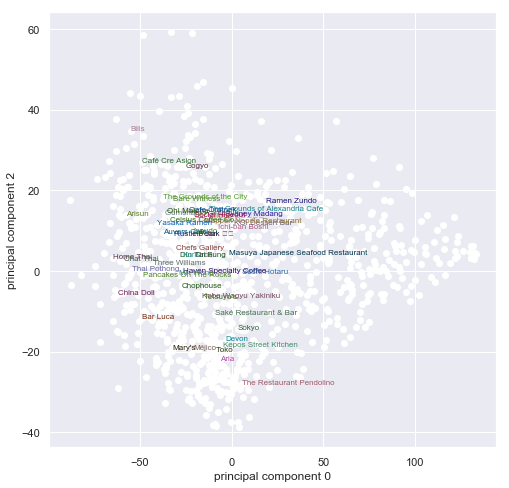

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(pca0,pca2,c='white')
for i, x, y in zip(names, pca0[:50], pca2[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.xlabel('principal component 0')
plt.ylabel('principal component 2')
plt.show()

In [15]:
from scipy.spatial.distance import cosine, euclidean

In [16]:
def nearest_neighbours(embeddings,from_index=None,from_name=None,names=names,to_df=True,cos=True):
    
    if from_index==None and from_name!=None: from_index = names.index(from_name)
        
    from_emb = embeddings[from_index]
    from_name = names[from_index] if from_name==None else from_name
    
    if cosine: dist = lambda x: cosine(from_emb,x)
    else: dist = lambda x: euclidean(from_emb,x)
    
    nn = sorted([(to_name,dist(to_emb)) 
                     for to_emb,to_name 
                         in zip(embeddings,names)]
                
                ,key=lambda x:x[1]
                ,reverse=False)
    
    if to_df: nn = pd.DataFrame(nn,columns=['name','distance']).drop_duplicates()
    
    return from_name,nn

# Clustering

In [23]:
from cluster_plot import plot_clusters, plot_label_dist, plot_3d_clusters
from sklearn.cluster import KMeans, SpectralClustering

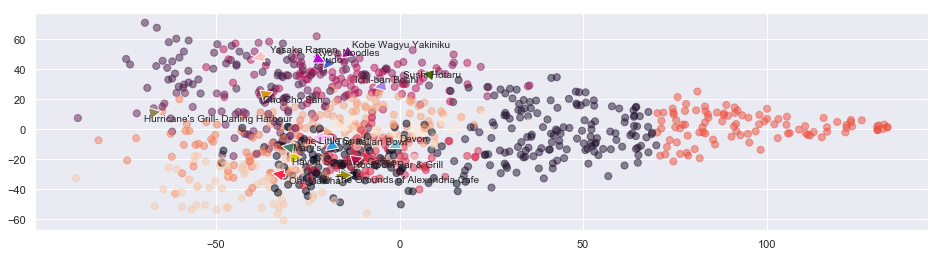

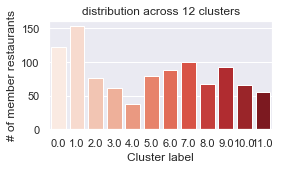

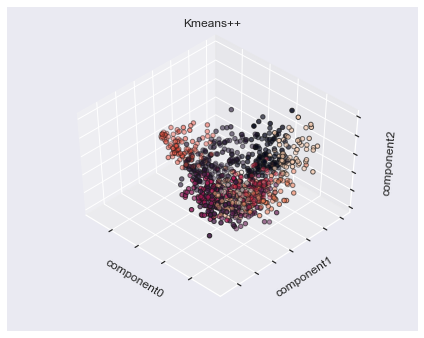

In [24]:
kplus = KMeans(n_clusters=12,init='k-means++').fit(embeds)

plot_clusters(kplus
              ,pc=principal_components
              ,text=True
              ,names=names
              ,n_names=15
              ,figsize=(16,4))

plot_label_dist(kplus,palette='Reds',figsize=(4,2))
plot_3d_clusters([('Kmeans++',kplus)],pc=principal_components,figsize=(6,4.5))

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, cosine, euclidean

In [26]:
def minimal_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    city = kwargs["city"]
    del kwargs["city"]
    
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram for {}'.format(city))
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [27]:
l = linkage(embeds, method='complete', metric='seuclidean')

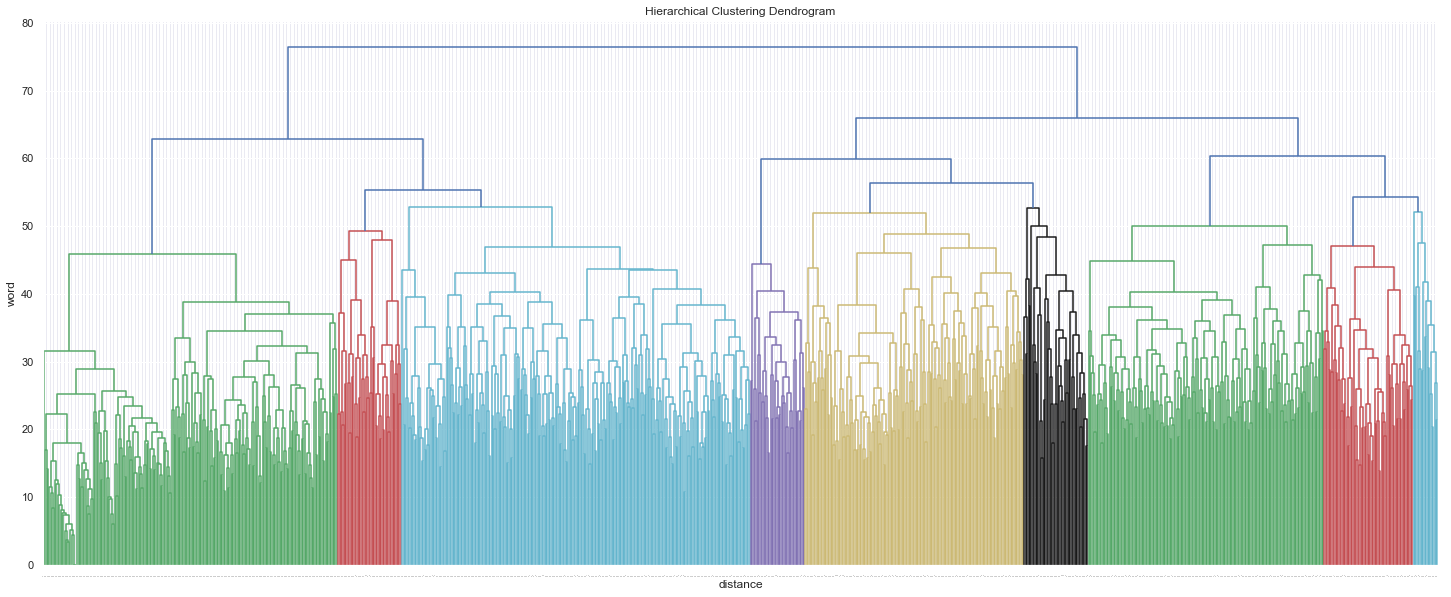

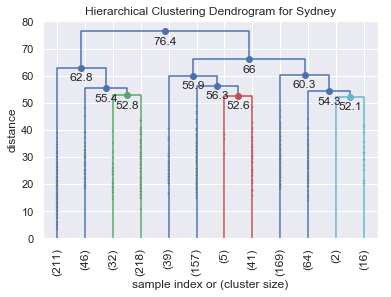

In [28]:
# calculate full dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=0.,  # font size for the x axis labels
    orientation='top',
)
plt.show()

minimal_dendrogram(
    l,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    city='Sydney'
)
plt.show()

In [29]:
corr, coph_dists = cophenet(l, pdist(embeds))
print('\nCophenetic correlation:', corr,'\n')


Cophenetic correlation: 0.4526770390414149 



Large clusters n:
4 

Medium clusters n:
27 

Small clusters n:
245 



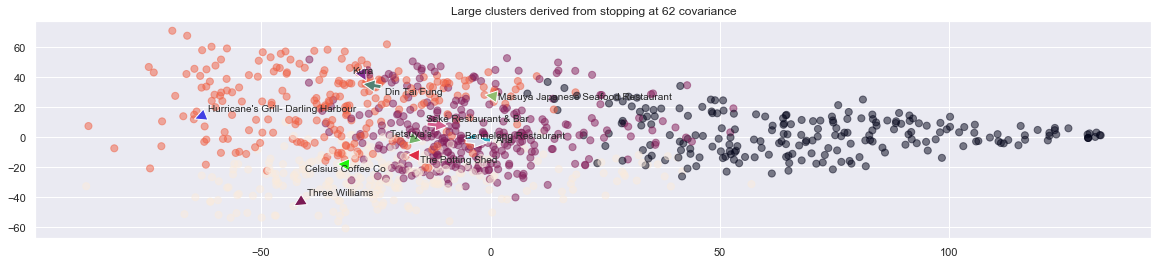

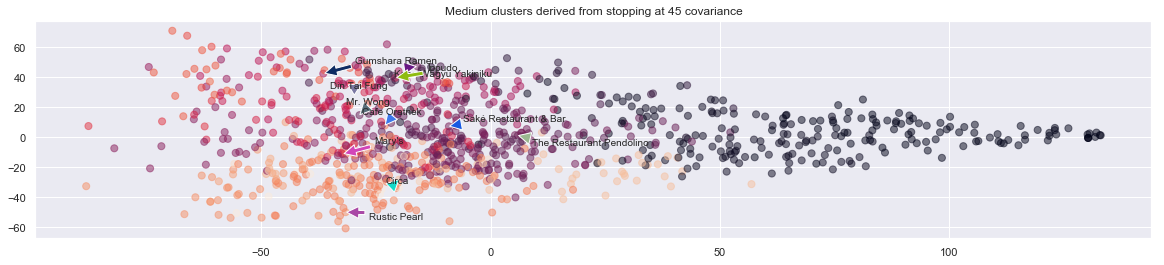

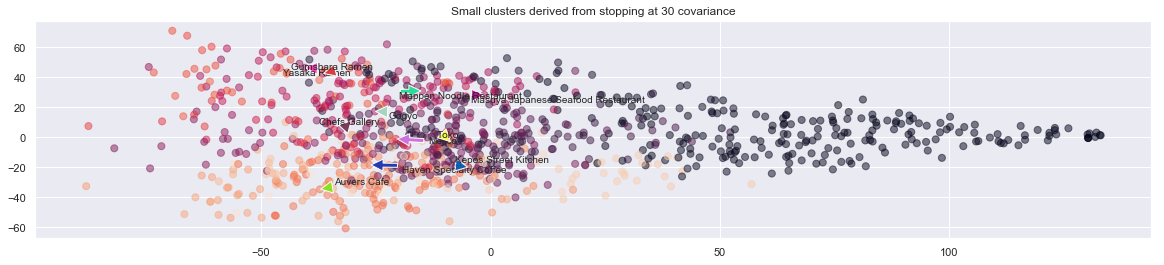

In [52]:
t_values = [('Large clusters',62),('Medium clusters',45),('Small clusters',30)]

agglom_labels = []

for label, t_value in t_values:
    print(label,'n:')
    clusters = fcluster(l, t=t_value, criterion='distance')
    print(len(np.unique(clusters)),'\n')

    agglom_labels += [clusters]
    
agglom_labels = np.array(agglom_labels)


for i in range(len(agglom_labels)): 
    plot_clusters(l,pc=principal_components
                  ,labels=agglom_labels[i]
                  ,names=names
                  ,text=True,figsize=(20,4)
                  ,title=('{} derived from stopping at {} covariance'
                         ).format(t_values[i][0],t_values[i][1]))
    plt.show()

In [57]:
### Build a cluster labels dataframe

metadata_df = pd.DataFrame(zip(names,food,principal_components[:,0],
                            principal_components[:,1],
                            principal_components[:,2])
                           ,columns=['name','cuisines','pca_0','pca_1','pca_2'])

metadata_df['agglomerative_l'] = agglom_labels[0]
metadata_df['agglomerative_m'] = agglom_labels[1]
metadata_df['agglomerative_s'] = agglom_labels[2]
metadata_df['kmeans++'] = kplus.labels_


embeddings_df = pd.DataFrame(embeds)
embeddings_df['name'] = names

In [58]:
def nearest_neighbours(embeddings,from_index=None,from_name=None,names=None,to_df=True,cos=True):
    
    if from_index==None and from_name!=None: from_index = names.index(from_name)
        
    from_emb = embeddings[from_index]
    from_name = names[from_index] if from_name==None else from_name
    
    if cosine: dist = lambda x: cosine(from_emb,x)
    else: dist = lambda x: euclidean(from_emb,x)
    
    nn = sorted([(to_name,dist(to_emb)) 
                     for to_emb,to_name 
                         in zip(embeddings,names)]
                
                ,key=lambda x:x[1]
                ,reverse=False)
    
    if to_df: nn = pd.DataFrame(nn,columns=['name','distance']).drop_duplicates()
    
    return from_name,nn



def meta_nearest_neighbours(metadata_df=metadata_df
                            ,embeddings=embeds
                            ,names=None
                            ,from_index=None
                            ,from_name=None):
    
    from_item, nn_df = nearest_neighbours(embeddings
                                         ,from_index=from_index
                                         ,from_name=from_name
                                         ,names=names
                                         ,to_df=True)
    
    return from_item, nn_df.merge(metadata_df
                        ).sort_values(by='distance'
                                 ).drop_duplicates(subset='name')
    
    

In [59]:
item,nn = meta_nearest_neighbours(from_name='Aqua S',names=list(names))

In [66]:
cluster_names = ['kmeans++'
                 ,'agglomerative_l','agglomerative_m'
                 ,'agglomerative_s']

print('Nearest neighbours for',item)

nn[['name',
    'agglomerative_l',
    'agglomerative_m',
    'agglomerative_s',
    'kmeans++']].head(5)

Nearest neighbours for Aqua S


,name,agglomerative_l,agglomerative_m,agglomerative_s,kmeans++
0,Aqua S,4,27,241,10
1,Cow & The Moon,4,27,245,0
2,The Choc Pot,4,24,231,0
3,Five Points Burgers,4,22,206,8
4,Peanut Butter Bar,4,27,242,10


In [67]:
import math
from collections import defaultdict


def ndcg(ranking
         ,cluster_cardinality
         ,binary=True
         ,receptive_field=1):
    
    dcg = lambda x: sum([rel/math.log(pos+2) for pos,rel in enumerate(x)])
    
    n = len(ranking) if (len(ranking) < cluster_cardinality) else cluster_cardinality
    
    actual_dcg = dcg(ranking)
    ideal_dcg = dcg([1] * n)
    normalized_dcg = actual_dcg / ideal_dcg
    
    return normalized_dcg


def rank_scores(item
                ,nn
                ,binarize=True
                ,k=10
                ,cluster_names=cluster_names):
    """
    Input: 
        nearest neighbours dataframe,
        k to represent size of list.
    
    Returns:
        A binarized ranking, where 1 is assigned to
    entries with matching clusters, and 0 otherwise.
    """
    
    rankings = {}
    
    nn.sort_values(by='distance')
    from_item = nn[nn.name==item]
    nn = nn[nn.name!=item]
    
    binarizer = lambda x:1 if x==0 else 0
    
    for c in cluster_names:
        n_clusters = len(set(nn[c].values))
        clusters = nn[c].values[:k]
        ground_truth = int(from_item[c])
        ground_size = nn[nn[c]==ground_truth].shape[0]
        
        continuous = [( abs(ground_truth - c) / ground_truth )
                        for c in list(clusters)]
        
        binarized = [binarizer(ground_truth-c) for c in clusters]
        
        rankings[c] = binarized if binarize else continuous
    
    return rankings


def evaluate(k
             ,names=None
             ,metric='ndcg'
             ,stop_at=50
             ,binary=True
             ,cluster_names=cluster_names):
    
    rankings = []
    
    for n in names[:stop_at]:
        item, nn = meta_nearest_neighbours(from_name=n,names=names)
        rankings += [(n,nn[nn.name==item],nn,rank_scores(item,nn,binarize=binary,k=k))]
    
    rows = []
    count = 0

    for n,item,nn,cluster_rankings in rankings:
        metrics = []
        
        for c in cluster_rankings.keys():
            ranking = cluster_rankings[c]
            cardinality = nn[nn[c]==item[c].values[0]].shape[0]
            metrics += [ndcg(ranking,cardinality)]
        
        metrics = [n] + metrics
        rows += [tuple(metrics)]
        
    metric_df = pd.DataFrame(rows,columns=['name'] + cluster_names)
    return metric_df

In [68]:
def results(top_k=20,stop_at=5,names=names):
    n_results = []
    b_results = []

    for i in range(1,top_k):
        print('{} of {} iterations complete...'.format(i-1,top_k))
        binary_df = evaluate(i,binary=True,names=list(names),stop_at=stop_at).drop('name',axis=1)
        normalized_df = evaluate(i,binary=False,names=list(names),stop_at=stop_at).drop('name',axis=1)

        b_results += [binary_df.apply(np.mean,axis=0).values]
        n_results += [normalized_df.apply(np.mean,axis=0).values]

        header = binary_df.apply(np.mean,axis=0).index

    binary_results = pd.DataFrame(b_results,columns=header)
    normalized_results = pd.DataFrame(n_results,columns=header)

    return [('binary',binary_results),('normalized',normalized_results)]

In [69]:
data = results(top_k=10,stop_at=100,names=list(names))

0 of 10 iterations complete...
1 of 10 iterations complete...
2 of 10 iterations complete...
3 of 10 iterations complete...
4 of 10 iterations complete...
5 of 10 iterations complete...
6 of 10 iterations complete...
7 of 10 iterations complete...
8 of 10 iterations complete...


In [70]:
data[0][1].to_csv('ndcg_binary_food.csv')

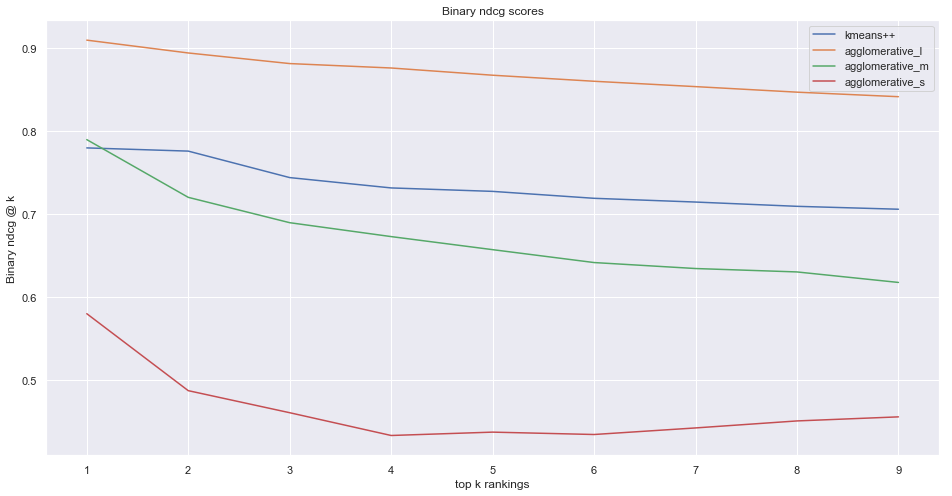

,kmeans++,agglomerative_l,agglomerative_m,agglomerative_s
0,0.780000,0.910000,0.790000,0.580000
1,0.776131,0.894526,0.720366,0.487155
2,0.744190,0.881732,0.689777,0.460540
3,0.731716,0.876397,0.673002,0.433069
4,0.727555,0.867685,0.657251,0.437120
5,0.719195,0.860390,0.641697,0.434254
6,0.714688,0.853940,0.634482,0.442181
7,0.709526,0.847242,0.630370,0.450626
8,0.706022,0.841777,0.617700,0.455537


In [71]:
X = range(1,10)

plt.figure(figsize=(16,8))

for Y in cluster_names:
    if Y=='affinity_propagation': pass
    else:
        sns.lineplot(y=Y,x=X,data=data[0][1],label=Y,legend='full'
                        ).set(xlabel='top k rankings'
                             ,ylabel='Binary ndcg @ k'
                             ,title='Binary ndcg scores'
                             )

plt.legend()
plt.show()

data[0][1]